calculate features for a subset of wikiart images and use correlation based method to transform them to another emotion
- 200 per emotion for feature extraction for which major emotion has probability >= 0.5
- 50 per emotoin for testing (feature transformation) where major emotion has probability <0.5
- evaluate transformation performance with classification model 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import cv2
from os import listdir
from os.path import join as p_join
from os.path import abspath
from pathlib import Path 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from skimage.feature import greycomatrix, greycoprops

%cd /content/drive/MyDrive/CP/Computational Photography
import importlib
import feature_extraction
import feature_transform
importlib.reload(feature_extraction)
importlib.reload(feature_transform)
from feature_extraction import calculateGLCMFeatures, calculateHSVFeatures, calculateLaplacian, rgb_values, rms_contrast, calculateFeatures
from feature_transform import change_laplacian, change_bgr, change_hsv
PROJDIR = abspath('')
PROJDIR

/content/drive/.shortcut-targets-by-id/1tMW7kRVrirU9R4wxlCq58YDRba-UZ3Tr/Computational Photography


In [ ]:
# put the path to the folder here 
# if this is a shared folder: right click on the folder in "Shared with me" directory, and then click "Add shortcut to Drive". 
# then you can access the data from your drive!
#PROJDIR = '/content/drive/MyDrive/CP/Computational Photography'
print(PROJDIR)
DATA = p_join(PROJDIR, 'data')
WIKIART = p_join(DATA, 'wikiart')

/content/drive/MyDrive/CP/Computational Photography


In [ ]:
groundtruth_file = p_join(PROJDIR, "wikiart_groundtruth.csv")
gt = pd.read_csv(groundtruth_file)
emotions = np.array(['something else', 'sadness', 'contentment', 'awe', 'amusement',
       'excitement', 'fear', 'disgust', 'anger'])
gt

,Unnamed: 0,painting,repetition,prob_something else,prob_sadness,prob_contentment,prob_awe,prob_amusement,prob_excitement,prob_fear,prob_disgust,prob_anger
0,0,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,10.0,0.300000,0.200000,0.200000,0.100000,0.000000,0.000000,0.100000,0.100000,0.0
1,1,wassily-kandinsky_study-for-autumn-1909,7.0,0.142857,0.000000,0.000000,0.428571,0.285714,0.000000,0.000000,0.142857,0.0
2,2,konstantin-korovin_yaroslavna-s-lament-1909,7.0,0.000000,0.142857,0.285714,0.142857,0.428571,0.000000,0.000000,0.000000,0.0
3,3,paul-gauguin_mette-gauguin-in-an-evening-dress...,7.0,0.000000,0.142857,0.142857,0.142857,0.285714,0.142857,0.142857,0.000000,0.0
4,4,pericles-pantazis_still-life-with-quinces-1880,7.0,0.142857,0.000000,0.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
80026,80026,pieter-bruegel-the-elder_go-ye-into-the-emmaus,5.0,0.200000,0.000000,0.200000,0.600000,0.000000,0.000000,0.000000,0.000000,0.0
80027,80027,albrecht-durer_the-small-chariot,5.0,0.000000,0.000000,0.200000,0.400000,0.000000,0.200000,0.000000,0.200000,0.0
80028,80028,albrecht-durer_sitting-mary-with-child,5.0,0.200000,0.200000,0.000000,0.400000,0.000000,0.000000,0.000000,0.200000,0.0
80029,80029,jan-van-hemessen_tobias-restores-his-father-s-...,5.0,0.000000,0.200000,0.000000,0.400000,0.000000,0.000000,0.000000,0.400000,0.0


In [ ]:
import random
def extractFeaturesWikiart(path, emotions: list, gt: pd.DataFrame):
    """
    path: path to training image data
    emotions: list of unique emotions in the same order as the probabilities in the ground truth data frame 
    gt: ground truth data frame with image name, probabilities, repetition
    """
    df = pd.DataFrame()
    folders = listdir(path)
    # for each (emotion) folder:
    for i, emotion_folder in enumerate(folders):
        if emotion_folder == "temp.jpg": 
            continue
        image_list = listdir(p_join(WIKIART, emotion_folder))
        image_list = sorted(image_list) 
        random.Random(4).shuffle(image_list)
        # for each image:
        count = 0
        print(len(image_list), "images found in", emotion_folder)
        for file in image_list:
            if count == 200:
                break
            # image name (remove ".jpg")
            image_name = file[:-4]
            # some image names contain weird characters that cannot be read
            if "©" in image_name:
                continue
            try:
                # find painting in ground truth data frame and copy row
                row = gt[gt["painting"] == image_name].iloc[0]
            except:
                print("not a valid file", file, image_name, count)
                continue
            # if hightest prob not > 0.5 do not use the image
            print(count, file, image_name)
            if np.max(row[3:].values) < 0.5:
                continue
            # find most likely emotion
            highest = np.argmax(row[3:].values)
            row['Emotion'] = emotions[highest]
            # calculate features and append to row
            im = cv2.imread(p_join(p_join(WIKIART, emotion_folder), file))
            row = calculateFeatures(row, im)
            count += 1
            # add image results to dataframe
            df = df.append(row, ignore_index=True)
    return df

uncomment this to extract the features

In [ ]:
#df = extractFeaturesWikiart(WIKIART, emotions, gt)
#df.to_csv(p_join(PROJDIR, "wikiart_features_major.csv"))

In [ ]:
from scipy.stats import kendalltau, pearsonr, spearmanr

def kendall_pval(x,y):
  return kendalltau(x,y)[1]
  
def pearsonr_pval(x,y):
  return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
  return spearmanr(x,y)[1]

read already extracted features from dataframe

In [ ]:
df = pd.read_csv(p_join(PROJDIR, "wikiart_features_major.csv"))
df

,Unnamed: 0,Unnamed: 0.1,painting,repetition,prob_something else,prob_sadness,prob_contentment,prob_awe,prob_amusement,prob_excitement,...,energy,correlation,hue,saturation,brightness,Laplacian,contrast2,blue,green,red
0,0,5195.0,konstantinos-parthenis_landscape-1911,6.0,0.5,0.166667,0.333333,0.000000,0.000000,0.0,...,0.025490,0.874241,65.967791,70.603794,125.370177,110.463916,29.548384,104.203116,112.394714,110.825072
1,1,26417.0,leon-berkowitz_cup-7-1975,5.0,0.6,0.200000,0.200000,0.000000,0.000000,0.0,...,0.075868,0.980302,102.225970,122.137192,154.960231,22.240464,14.613010,140.922603,111.057325,97.669424
2,2,1042.0,tia-peltz_baba-cloan-a,6.0,0.5,0.000000,0.000000,0.000000,0.000000,0.0,...,0.006594,0.583508,30.734191,87.159674,146.431723,2655.182596,63.033411,99.545028,133.945142,143.244553
3,3,18571.0,ilya-repin_kubana-1883,6.0,0.5,0.000000,0.166667,0.166667,0.166667,0.0,...,0.081234,0.716204,0.000000,0.000000,178.873058,2018.902083,91.632653,178.873058,178.873058,178.873058
4,4,9391.0,henri-fantin-latour_bowl-of-peaches-1869,6.0,0.5,0.000000,0.500000,0.000000,0.000000,0.0,...,0.011001,0.680647,64.879136,142.413508,104.004949,4726.317053,39.849356,51.653394,59.903208,103.995770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,1637,7778.0,henri-matisse_not-identified-25,6.0,0.0,0.000000,0.333333,0.000000,0.166667,0.0,...,0.012138,0.715174,74.490494,95.633218,175.559518,1305.993068,41.956395,122.113400,150.620641,171.054041
1638,1638,34615.0,fra-angelico_st-stephen-being-led-to-his-marty...,6.0,0.0,0.166667,0.000000,0.333333,0.000000,0.0,...,0.007430,0.739446,34.607370,81.841554,167.371556,5098.863418,62.565434,121.693167,135.811150,166.273321
1639,1639,38097.0,guido-molinari_untitled-1966,5.0,0.2,0.000000,0.000000,0.000000,0.200000,0.0,...,0.069489,0.963759,107.906893,171.733365,134.226722,109.377553,21.981410,71.196473,27.331722,85.106439
1640,1640,37564.0,frank-lobdell_dance-iv-1970,5.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.020021,0.883223,28.529084,67.048533,152.875716,2543.714806,81.763454,117.771618,129.612961,150.621873


In [ ]:
df.columns = ['Unnamed: 0', 'Unnamed: 0.1', 'painting', 'repetition', 'something else',
       'sadness', 'contentment', 'awe', 'amusement',
       'excitement', 'fear', 'disgust', 'anger', 'Emotion',
       'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy',
       'correlation', 'hue', 'saturation', 'brightness', 'Laplacian',
       'contrast2', 'blue', 'green', 'red']

In [ ]:
major = df[df[["something else", "sadness", "contentment", "awe", "amusement", "excitement", "fear", "disgust", "anger"]].values.max(axis=1)>=0.5]
len(major) == len(df) #check if really only major emotion images in the dataframe

True

get the p-values

In [ ]:
def get_pvals(feature_df, columns = ["hue","saturation","brightness","Laplacian","blue","green","red"]):
    p_val = feature_df.corr(method=spearmanr_pval)[feature_df.corr().columns[3:12]].T[feature_df.corr().columns[12:]]
    p_val_short = p_val.iloc[:,6:] # hue saturation brightness laplace contrast2 blue green red
    p_val_short = pd.concat([p_val_short, p_val.iloc[:,0]], axis=1) # add contrast1
    p_val_short = p_val_short[columns] # resort
    return p_val_short

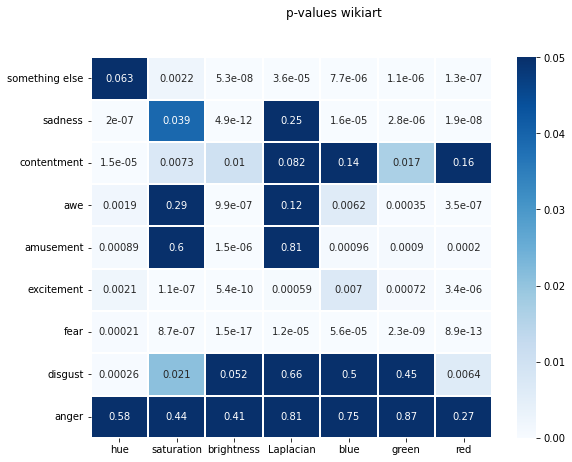

In [ ]:
p_val_s = get_pvals(major, ["hue",	"saturation",	"brightness",	"Laplacian",	"blue",	"green",	"red"])
out_pdf = p_join(PROJDIR,'wikiart_pval.pdf')
pdf = matplotlib.backends.backend_pdf.PdfPages(out_pdf)
plt.figure(figsize=(9,7))
heat_map = sns.heatmap( p_val_s, linewidth = 1 , annot = True, cmap="Blues", vmin=0.0, vmax=0.05)
plt.suptitle("p-values wikiart")
pdf.savefig()
pdf.close()

get mean feature values per emotion:

In [ ]:
# choose only features that we can use for transformation
feature_means = df.groupby(['Emotion']).mean()[["hue",	"saturation",	"brightness",	"Laplacian","blue",	"green",	"red"]]
feature_means

,hue,saturation,brightness,Laplacian,blue,green,red
Emotion,,,,,,,
amusement,47.642774,91.687046,150.093821,1966.308435,108.406420,125.875494,142.378092
anger,41.627850,94.812971,152.746944,3833.200110,107.958143,120.162224,145.678365
awe,48.958111,86.015311,131.773511,2166.635657,97.031150,111.441116,125.921583
contentment,50.289548,86.571735,148.268587,1918.274201,111.467110,128.351264,138.236577
disgust,39.944357,93.390221,146.419835,1778.458004,101.742917,120.836810,142.193055
excitement,49.927483,101.835008,152.718352,2765.405772,106.882513,124.608657,142.269546
fear,42.534173,71.007339,118.401246,5165.979719,92.604795,102.967713,114.781733
sadness,39.725065,81.329820,126.610152,3272.230952,94.541240,109.538459,122.889536
something else,49.863925,79.902331,157.781094,2221.783394,120.448914,135.940591,151.505768


create mapping for feature transformation

In [ ]:
def create_mapping_dictionary(p_val, means, emotions, use_pval=2):
    """
    returns dataframe that tells which features to change with which value for each pair of original and target emotion
    @param p_val p-values that were calculated using the training data of this data set
    @param means mean feature values by emotion. Used to determine the amount of change for a mapping of one emotion to the other
    """
    features = p_val.columns
    df = pd.DataFrame()
    for original in emotions:
        for target in emotions:
            if original == target:
                continue
            row = {}
            row['original'] = original
            row['target'] = target
            # mask that tells whether each features are relevant for both emotions
            relevant_p_val_original = (p_val<0.05).loc[[original]].values
            relevant_p_val_target = (p_val<0.05).loc[[target]].values
            overall_p_val = relevant_p_val_target & relevant_p_val_original

            # mean values of the RELEVANT features of TARGET and ORIGINAL emotion, because anger does not have any p-val smaller than 0.05, we use all features
            if use_pval == 2 and target != "anger" and original != "anger":
                mean_features_target = (means.loc[[target]].values * overall_p_val)[0]
            # mean values of the RELEVANT features of TARGET emotion
            elif use_pval == 1 and target != "anger":
                mean_features_target = (means.loc[[target]].values * relevant_p_val_target)[0]
            # mean values of all features
            else:
                mean_features_target = (means.loc[[target]].values)[0]

            for i, f in enumerate(features):
                row[f] = mean_features_target[i]
            df = df.append(row, ignore_index=True)
    return df
mapping = create_mapping_dictionary(p_val_s, feature_means, emotions, 2)
# example: 
mapping[(mapping['original']=='sadness') & (mapping['target']=='awe')]

,original,target,hue,saturation,brightness,Laplacian,blue,green,red
10,sadness,awe,48.958111,0.0,131.773511,0.0,97.03115,111.441116,125.921583


## Testing (feature transformation)


/content/drive/MyDrive/CP/Computational Photography/data/wikiart


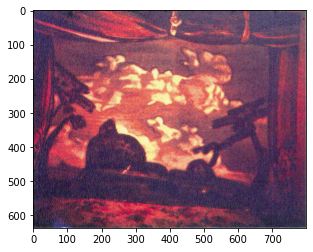

before: mean blue=129.21, mean green=73.12, mean red=92.13
after: mean blue=198.62, mean green=194.55, mean red=190.09


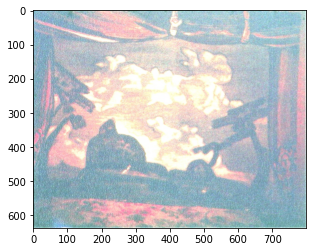

In [ ]:
# example change bgr
dir = p_join(p_join(WIKIART, 'fear'))

image_path = p_join(dir, listdir(dir)[12])
# read file and store in temporary file that can be manipulated
im = cv2.imread(image_path)
folder = image_path.rsplit('/', 2)[0]
print(folder)

temp_file = p_join(folder, 'temp.jpg')
cv2.imwrite(temp_file, im)

#see what it looks like originally 
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.show()
print(f"before: mean blue={im[:,:,0].mean():.2f}, mean green={im[:,:,1].mean():.2f}, mean red={im[:,:,2].mean():.2f}")

# change to the given new means and look at the result
im = change_bgr(temp_file, [200,200,200]) # bgr
print(f"after: mean blue={im[:,:,0].mean():.2f}, mean green={im[:,:,1].mean():.2f}, mean red={im[:,:,2].mean():.2f}")
im = cv2.imread(temp_file, cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)


load model

In [ ]:
%cd /content/drive/MyDrive/CP/Computational Photography
%cd artemis
!pip install -e .

/content/drive/.shortcut-targets-by-id/1tMW7kRVrirU9R4wxlCq58YDRba-UZ3Tr/Computational Photography
/content/drive/.shortcut-targets-by-id/1tMW7kRVrirU9R4wxlCq58YDRba-UZ3Tr/Computational Photography/artemis
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/.shortcut-targets-by-id/1tMW7kRVrirU9R4wxlCq58YDRba-UZ3Tr/Computational%20Photography/artemis
  Attempting uninstall: artemis
    Found existing installation: artemis 0.1
    Can't uninstall 'artemis'. No files were found to uninstall.
  Running setup.py develop for artemis


In [ ]:
from google.colab.patches import cv2_imshow
from artemis.neural_models.resnet_encoder import ResnetEncoder
from artemis.neural_models.image_emotion_clf import ImageEmotionClassifier
from artemis.neural_models.mlp import MLP
from PIL import Image
import torch
import random
import warnings
import numpy as np
import pandas as pd
import os.path as osp
import multiprocessing as mp
import torchvision.transforms as transforms

In [ ]:
from artemis.in_out.neural_net_oriented import torch_load_model, torch_save_model, save_state_dicts
import os.path as osp
save_dir = './model_temp'  # for trained model
checkpoint_file = osp.join(save_dir, 'best_model_artemis.pt')

model = torch_load_model(checkpoint_file)    

In [ ]:
image_net_mean = [0.485, 0.456, 0.406]
image_net_std = [0.229, 0.224, 0.225]

def image_transformation(img_dim, lanczos=True):
    """simple transformation/pre-processing of image data."""

    if lanczos:
        resample_method = Image.LANCZOS
    else:
        resample_method = Image.BILINEAR

    normalize = transforms.Normalize(mean=image_net_mean, std=image_net_std)
    img_transforms = dict()
    img_transforms['train'] = transforms.Compose([transforms.Resize((img_dim, img_dim), resample_method),
                                                  transforms.ToTensor(),
                                                  normalize])

    # Use same transformations as in train (since no data-augmentation is applied in train)
    img_transforms['test'] = img_transforms['train']
    img_transforms['val'] = img_transforms['train']
    img_transforms['rest'] = img_transforms['train']
    return img_transforms

function to classify image

In [ ]:
def classify(name, model, emotions):
    #img_name=p_join(EM_train, "sadness/100.jpg")
    img=cv2.imread(name)

    img = Image.open(name)
    if img.mode is not 'RGB':
        img = img.convert('RGB')
    img_transform=image_transformation(256)['train']
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    img_inp = torch.unsqueeze(img_transform(img).to(device),0)

    out=model(img_inp)
    max_pred = np.argmax(out.detach().cpu().numpy(), 1)    
    probabilities = out.cpu().detach().numpy()[0]
    return emotions[int(max_pred)], probabilities

function that transforms emotion and writes result to temporary file

In [ ]:
def transform_emotion(target_values, image_path, temp_path):
    # read image and store in temporary file in which we store the changed temporary file after each manipulation step
    # use a temporary file because some functions use cv2 and others PIL, also we do not want to overwrite the original file
    # returns manipulated image
    im = cv2.imread(image_path)
    #folder = image_path.rsplit('/', 2)[0]
    cv2.imwrite(temp_path, im)

    # change feature values to mean values of target emotion
    change_bgr(temp_path, target_values[['blue', 'green', 'red']].values[0])
    if np.all(target_values[['blue', 'green', 'red']].values[0]==0):
        change_hsv(temp_path, target_values[['hue', 'saturation', 'brightness']].values[0], change_hue=True)
    else:
        change_hsv(temp_path, target_values[['hue', 'saturation', 'brightness']].values[0], change_hue=False)
  
    x = change_laplacian(temp_path, target_values['Laplacian'].values)
    return

In [ ]:
gt.columns = ["Unnamed", "painting", "repitition", "something else", "sadness", "contentment", "awe", "amusement", "excitement", "fear", "disgust", "anger"]

In [ ]:
mapping[(mapping['original']=="something else")]

,original,target,contrast,hue,saturation,brightness,Laplacian,contrast2,blue,green,red
0,something else,sadness,0.010667,0.00000,81.329820,126.610152,0.000000,51.136759,94.541240,109.538459,122.889536
1,something else,contentment,0.002667,0.00000,86.571735,148.268587,0.000000,50.971701,0.000000,128.351264,0.000000
2,something else,awe,0.000000,0.00000,0.000000,131.773511,0.000000,0.000000,97.031150,111.441116,125.921583
3,something else,amusement,0.008000,0.00000,0.000000,150.093821,0.000000,0.000000,108.406420,125.875494,142.378092
4,something else,excitement,0.004667,0.00000,101.835008,152.718352,2765.405772,0.000000,106.882513,124.608657,142.269546
5,something else,fear,0.015288,0.00000,71.007339,118.401246,5165.979719,57.184790,92.604795,102.967713,114.781733
6,something else,disgust,0.000000,0.00000,93.390221,0.000000,0.000000,0.000000,0.000000,0.000000,142.193055
7,something else,anger,0.579365,41.62785,94.812971,152.746944,3833.200110,52.490129,107.958143,120.162224,145.678365


In [ ]:
em = "awe"
dir = p_join(WIKIART, em)

for target in emotions:
    count = 0
    for img in listdir(dir)[4:]:
        if count == 1:
            break
        count += 1
        image_id = img.split(".")[0]
        image_path = p_join(dir, img)

        # retrieve ground truth distribution for current image
        groundtruth = gt[(gt['painting']==image_id)]
        probabilities = groundtruth.values[0,3:] # ground truth probabilities

        # compute most likely emotion
        label = emotions[np.argmax(probabilities)]
        if target==label: continue

        im = cv2.imread(image_path)
        row = {}
        row = calculateFeatures(row, im)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        #plt.imshow(im)
        #plt.show()
        print(label, 'to', target)
        #print(f"before transformation:\nhue={row['hue']:.2f}, brightness={row['brightness']:.2f}, saturation={row['saturation']:.2f}, \nred={row['red']:.2f}, blue={row['blue']:.2f}, green={row['green']:.2f},\ncontrast2={row['contrast2']:.2f}, laplacian={row['Laplacian']:.2f}")

        target_values = mapping[(mapping['original']==label) & (mapping['target']==target)]
        #print(f"goal:\nhue={target_values['hue'].values[0]:.2f}, brightness={target_values['brightness'].values[0]:.2f}, saturation={target_values['saturation'].values[0]:.2f}, \nred={target_values['red'].values[0]:.2f}, blue={target_values['blue'].values[0]:.2f}, green={target_values['green'].values[0]:.2f},\ncontrast2={target_values['contrast2'].values[0]:.2f}, laplacian={target_values['Laplacian'].values[0]:.2f}")

        temp_path = p_join(WIKIART, "temp.jpg")
        _ = transform_emotion(target_values, image_path, temp_path)
        print("assigned=", classify(temp_path, model, emotions)[0])
        row = {}
        im = cv2.imread(temp_path)
        row = calculateFeatures(row, im)
        #print(f"after transformation:\nhue={row['hue']:.2f}, brightness={row['brightness']:.2f}, saturation={row['saturation']:.2f}, \nred={row['red']:.2f}, blue={row['blue']:.2f}, green={row['green']:.2f},\ncontrast2={row['contrast2']:.2f}, laplacian={row['Laplacian']:.2f}")
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        #plt.imshow(im)
        #plt.show()

awe to something else
assigned= contentment


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


awe to sadness
assigned= something else
awe to contentment
assigned= something else
awe to amusement
assigned= contentment
awe to excitement
assigned= contentment
awe to fear
assigned= something else
awe to disgust
assigned= contentment
awe to anger
assigned= something else


In [1]:
def emotion_transform_wikiart(path, groundtruth, emotions, model, mapping):
    """
    path = path to folder in which there is a folder for each emotion6 class except neutral
    groundtruth = dataframe with the same structure as the wikiart groundtruth dataframe, contains all images that should be used for the transformation
    emotions = list of emotions 
    model = model for classification
    mapping = df with entry for each pair of gt-emotion and target emotion that contains which features should be transformed to what degree
    """
    df = pd.DataFrame()
    folders = listdir(path)[:-1] # do not use the "temp.jpg" file
    # for each folder (folders are named with emotions which are not necessarily the most probable emotion for the images in the folder):
    for f in folders:
        emotion_folder_path = p_join(path, f)
        l = listdir(emotion_folder_path)
        print(emotion_folder_path)
        count = 0
        # for each image:
        for file in l:
            if count == 50:
                break
            image_id = file[:-4]
            image_path = p_join(emotion_folder_path, file)
            im = cv2.imread(image_path)
            #print(f"before transformation:\nhue={row['hue']:.2f}, brightness={row['brightness']:.2f}, saturation={row['saturation']:.2f}, red={row['red']:.2f}, blue={row['blue']:.2f}, green={row['green']:.2f}, contrast2={row['contrast2']:.2f}, laplacian={row['Laplacian']:.2f}")

            # retrieve ground truth distribution for current image
            gt = groundtruth[groundtruth["painting"] == image_id]
            if gt.empty:
                continue
          
            probabilities = gt.values[0,3:] # ground truth probabilities
            # if there is no clear label, skip the image
            if len(np.where(probabilities == np.max(probabilities))[0]) != 1:
                continue

            # compute most likely emotion
            label = emotions[np.argmax(probabilities)]
            # predict emotion before transformation with model
            predicted_in, _ = classify(image_path, model, emotions)

            count += 1
            print(count)

            # all possible target emotions
            for target in emotions:
                if target==label:
                    continue
                target_values = mapping[(mapping['original']==label) & (mapping['target']==target)]
                temp_path = p_join(path, "temp.jpg")
                #print(f"goal {label} to {target}:\nhue={target_values['hue'].values[0]:.2f}, brightness={target_values['brightness'].values[0]:.2f}, saturation={target_values['saturation'].values[0]:.2f}, red={target_values['red'].values[0]:.2f}, blue={target_values['blue'].values[0]:.2f}, green={target_values['green'].values[0]:.2f}, contrast2={target_values['contrast2'].values[0]:.2f}, laplacian={target_values['Laplacian'].values[0]:.2f}")
                transform_emotion(target_values, image_path, temp_path)

                row = {}
                row['folder'] = f
                row['image'] = file #image name
                row['Emotion'] = label #most likely emotion
                row['target'] = target #target emotion

                # predict emotion after transformation
                predicted_out, probabilities_out = classify(temp_path, model, emotions)
                #print("before:", label, "wanted:", target, "after:", predicted_out)
                row['predicted_in'] = predicted_in
                row['predicted_out'] = predicted_out
                # add image results to dataframe
                df = df.append(row, ignore_index=True)
    return df

get test images: those where the major emotion is smaller than 0.5.
We use 50 out of each class for the transformation

In [ ]:
test_df = gt[gt[["something else", "sadness", "contentment", "awe", "amusement", "excitement", "fear", "disgust", "anger"]].values.max(axis=1) < 0.5]
 #df[df[["something else", "sadness", "contentment", "awe", "amusement", "excitement", "fear", "disgust", "anger"]].values.max(axis=1)>=0.5]

In [ ]:
test_df

,Unnamed,painting,repitition,something else,sadness,contentment,awe,amusement,excitement,fear,disgust,anger
0,0,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,10.0,0.300000,0.200000,0.200000,0.100000,0.000000,0.000000,0.100000,0.100000,0.0
1,1,wassily-kandinsky_study-for-autumn-1909,7.0,0.142857,0.000000,0.000000,0.428571,0.285714,0.000000,0.000000,0.142857,0.0
2,2,konstantin-korovin_yaroslavna-s-lament-1909,7.0,0.000000,0.142857,0.285714,0.142857,0.428571,0.000000,0.000000,0.000000,0.0
3,3,paul-gauguin_mette-gauguin-in-an-evening-dress...,7.0,0.000000,0.142857,0.142857,0.142857,0.285714,0.142857,0.142857,0.000000,0.0
10,10,vasily-surikov_young-lady-with-violet-overcoat,7.0,0.000000,0.285714,0.428571,0.142857,0.000000,0.000000,0.142857,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
80025,80025,joachim-wtewael_mars-and-venus-discovered-by-t...,5.0,0.000000,0.000000,0.000000,0.200000,0.400000,0.400000,0.000000,0.000000,0.0
80027,80027,albrecht-durer_the-small-chariot,5.0,0.000000,0.000000,0.200000,0.400000,0.000000,0.200000,0.000000,0.200000,0.0
80028,80028,albrecht-durer_sitting-mary-with-child,5.0,0.200000,0.200000,0.000000,0.400000,0.000000,0.000000,0.000000,0.200000,0.0
80029,80029,jan-van-hemessen_tobias-restores-his-father-s-...,5.0,0.000000,0.200000,0.000000,0.400000,0.000000,0.000000,0.000000,0.400000,0.0


do the transformation for test images

In [ ]:
test_labels = emotion_transform_wikiart(WIKIART, test_df, emotions, model, mapping)

In [ ]:
print("correctly classified before transformation \t", (test_labels['Emotion'].values == test_labels["predicted_in"].values).sum() / len(test_labels))
print("classified as target before transformation \t", (test_labels["target"].values == test_labels["predicted_in"].values).sum() / len(test_labels))
print("classified as target after transformation \t", (test_labels["target"].values == test_labels["predicted_out"].values).sum() / len(test_labels))
print("fraction were prediction did not change \t", (test_labels["predicted_in"].values == test_labels["predicted_out"].values).sum() / len(test_labels))

for e in emotions:
    print("classified as", e, "before transformation:\t", ((test_labels["target"] == e) & (test_labels["predicted_in"] == e)).sum(),"\tAfter transformation ", ((test_labels["target"] == e) & (test_labels["predicted_out"] == e)).sum())


correctly classified before transformation 	 0.18
classified as target before transformation 	 0.1025
classified as target after transformation 	 0.11166666666666666
fraction were prediction did not change 	 0.7597222222222222
classified as something else before transformation:	 55 	After transformation  53
classified as sadness before transformation:	 56 	After transformation  52
classified as contentment before transformation:	 139 	After transformation  161
classified as awe before transformation:	 16 	After transformation  11
classified as amusement before transformation:	 0 	After transformation  0
classified as excitement before transformation:	 4 	After transformation  2
classified as fear before transformation:	 37 	After transformation  59
classified as disgust before transformation:	 20 	After transformation  19
classified as anger before transformation:	 42 	After transformation  45


In [ ]:
test_labels.to_csv(p_join(PROJDIR, 'wikiart_pvaluefilter.csv'))